Checks-DESTINY.ipynb
Checks.ipynb
Fig 1.ipynb
Fig 3 -- Timeseries.ipynb
Fig 5 A -- Meteoroid Data Reader-Spectogram- outgoing-no_vel + orbit.ipynb
Fig 5 B -- Meteoroid Data Reader-Spectogram- outgoing-vel + orbit-Copy1.ipynb
data
elements.ipynb
spectogram_2.ipynb


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy
import spiceypy as spice
import rebound
import reboundx
import matplotlib
import pandas as pd
import scipy.signal

plt.rcParams.update({
  # "text.usetex": True,
  # "font.family": "Computer Modern Roman",
  "font.size":    14.0
})

In [2]:
import sys
sys.path.append('..')
from geminids.weights import *
from geminids.beta2mass import asteroidal as asteroidal
from geminids.constants import *
from geminids.cometary_start import init_loc
from geminids.read_data import *

In [2]:
points_novel = []
points_vel = []
points_distr = []
n = 100
pth = "../output/"

for i in tqdm(range(n)):
    data = np.load(f'{pth}novel/particles{i}.npy')
    beta = np.load(f'{pth}novel/beta{i}.npy')
    size = np.load(f'{pth}novel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(10000*10*2, 5)
    data = data[:,:3]
    
    
    
    points_novel.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), 
                                   np.tile(weight_novel(beta),2000).reshape(200000,1))))
    
points_novel = np.array(points_novel)
points_novel = points_novel.reshape(200000*n,5)
n=100
for i in tqdm(range( n)):
    data = np.load(f'{pth}vel/particles{i}.npy')
    beta = np.load(f'{pth}vel/beta{i}.npy')
    size = np.load(f'{pth}vel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(1000*100*2, 5)
    data = data[:,:3]
    
    
    
    points_vel.append(np.hstack((data, np.tile(size,2000).reshape(200000,1),
                                 np.tile(weight_vel(beta),2000).reshape(200000,1))))
    
points_vel = np.array(points_vel)
points_vel = points_vel.reshape(200000*n,5)
offset = 0
n = 1000
orbit = np.load("../data/orig_orbit.npy")
for i in tqdm(range(n)):
        # try:
            data = np.load(f'{pth}comet/particles{i}.npy')
            beta = np.load(f'{pth}comet/beta{i}.npy')
            size = np.load(f'{pth}comet/mass{i}.npy')
            mask = beta < .5
            size[mask] = asteroidal(beta[mask])
            size[~mask] = 0
            data = data.reshape(10000*10*2, 5)
            # try:
                
            __, r, t = init_loc(int(i/10), orbit)
            t = np.tile(t, 100)
            r = np.tile(r, 100)
            # except Exception as e:
                # print(e)
            # data[data[:,4] < .2] *= 0
            data = data[:,:3]
            # beta = np.tile(beta, 20000).reshape(200000,)
            # print(beta.shape)
            
            # w = weight_cometary(beta, r, t)
            # print(w.shape)
            # print(r)

            points_distr.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), 
                                   np.tile(weight_cometary(beta, r, t),2000).reshape(200000,1),
                                   np.tile(r,2000).reshape(200000,1))))
        # except Exception as e: 
        #     print(e)
        #     offset +=1

points_distr = np.array(points_distr)
points_distr = points_distr.reshape(200000*(n - offset),6)
points_novel = points_novel[~np.isnan(points_novel).any(axis=1)]
points_vel = points_vel[~np.isnan(points_vel).any(axis=1)]
points_distr = points_distr[~np.isnan(points_distr).any(axis=1)]
points_distr = points_distr[points_distr[:,0] != 0]


orbit = np.load('../geminids/data/phaethon.npy')
psp2 = np.load('../geminids/data/psp.npy')
orbit = orbit.reshape((20000,5))[:,:3].copy()
psp2 = psp2[:,:3].copy()


transform = spice.pxform("J2000", "ECLIPJ2000", 0)

print("Transforming")

# points_novel[:,:3] = np.dot(transform, points_novel[:,:3].T).T
# points_vel[:,:3] = np.dot(transform, points_vel[:,:3].T).T
# points_distr[:,:3] = np.dot(transform, points_distr[:,:3].T).T
orbit = np.dot(transform, orbit.T).T
psp2 = np.dot(transform, psp2.T).T

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'asteroidal' is not defined

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


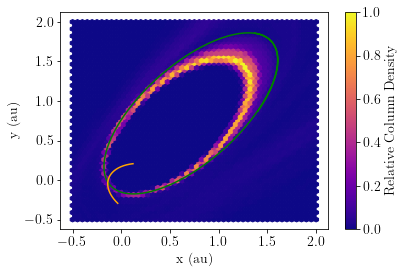

In [3]:
points_novel = load(100, 0)
orbit = get_phaethon_orbit()
psp2 = get_parker_orbit()
plot_column_density(points_novel, orbit, psp2)
plot_column_density(points_novel, orbit, psp2, plane='yz')

100%|██████████| 1000/1000 [08:10<00:00,  2.04it/s]


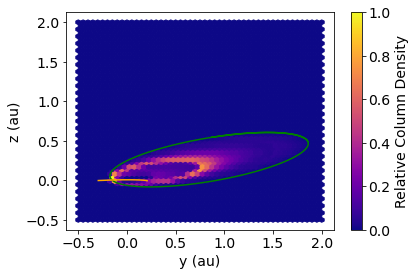

In [4]:
points_distr = load(1000, 2)
orbit = get_phaethon_orbit()
psp2 = get_parker_orbit()
plot_column_density(points_distr, orbit, psp2)
plot_column_density(points_distr, orbit, psp2, plane='yz')

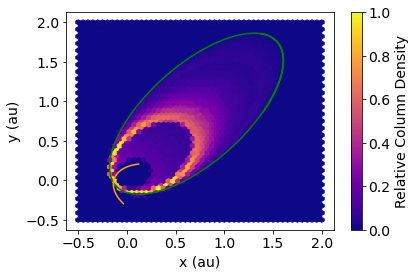

In [5]:
plot_column_density(points_distr, orbit, psp2)


In [10]:
!pip install cmr12

ERROR: Could not find a version that satisfies the requirement cmr12 (from versions: none)
ERROR: No matching distribution found for cmr12


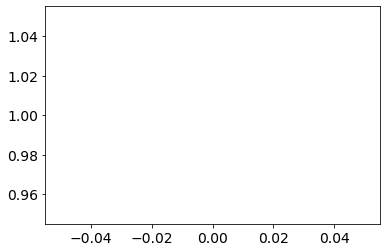

In [3]:
plt.plot([0,0], [1,1])

In [43]:
points_distr[:,4] = np.abs(points_distr[:,4])

In [44]:
data2 = np.load(f'{pth}comet/particles{i}.npy')
len(data2)


2000

In [45]:
data2.shape

(2000, 100, 5)

In [4]:
# normalize to 1e18 g


masses = np.load("../cache/masses.npy")

norm_vel = masses[1] / np.sum(points_vel[:,3])
norm_novel = masses[0] / np.sum(points_novel[:,3])
norm_distr = masses[2] / np.sum(points_distr[:,3])

NameError: name 'points_vel' is not defined

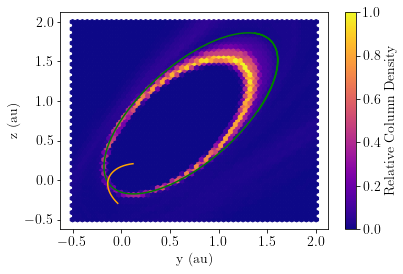

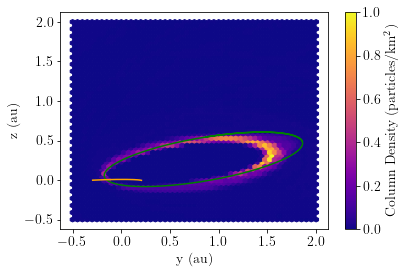

In [4]:
grid=50

x = np.linspace(-.5, 2.5, grid*2)
y = np.linspace(-.5, 2.5, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_novel[:,0], nx.flatten())), np.hstack((points_novel[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_novel[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)






plt.colorbar(label = "Relative Column Density")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot(psp2[:,0], psp2[:,1], c='orange', label = "Parker Solar Probe")

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.1.eps")
plt.show()



poly = plt.hexbin(np.hstack((points_novel[:,1], nx.flatten())), np.hstack((points_novel[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_novel[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)




plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.2.eps")
plt.show()

In [48]:
r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)
peri = np.argmin(r)

(-0.2, 0.1)

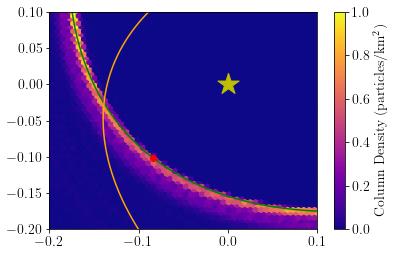

In [135]:
grid=50
extent=(-.2,0.1,-.2,.1)

x = np.linspace(extent[0], extent[1], grid*2)
y = np.linspace(extent[2], extent[3], grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_novel[:,0], nx.flatten())), np.hstack((points_novel[:,1], ny.flatten())), cmap = "plasma", 
                  extent = extent, gridsize=grid, C = np.hstack((points_novel[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)


plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid, extent = extent)
plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot([orbit[peri,0]], [orbit[peri,1]], "r-o")
plt.scatter([0], [0], marker="*", c='y', s=500)
plt.plot(psp2[:,0], psp2[:,1], c='orange')

plt.xlim(extent[0], extent[1])
plt.ylim(extent[2], extent[3])

In [136]:
def quadratic(x, a, b, c):
    return a*(x**2) + b * (x**1)  + c 

In [296]:
r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)
peri = np.argmin(r)
extent=(-.3,.2,-.3,.2)

# def sigmoid(x, sigma, a):
#     return 1/(1 + np.exp(-(x-a)/(sigma**2)))

# def sigmoid_sum(x, sigma_1, sigma_2, a_1, a_2, b):
#     return (sigmoid(x, sigma_1, a_1) + b * sigmoid(x, sigma_2, a_2))/(1+b)

# def d_sig(x, sigma, a):
#     exp = np.exp((a-x)/sigma**2)
#     return ( 1 * exp) / (sigma**2 * (exp + 1)**2)
# def d_sig_sum(x, sigma_1, sigma_2, a_1, a_2, b):
#     return 1/(1+b) * (d_sig(x, sigma_1, a_1) + b * d_sig(x, sigma_2, a_2))


mask = (points_novel[:,0] > extent[0]) * (points_novel[:,0] < extent[1]) * (points_novel[:,1] > extent[2]) * (points_novel[:,1] < extent[3])
orbit_mask = (orbit[:,0] > extent[0]) * (orbit[:,0] < extent[1]) * (orbit[:,1] > extent[2]) * (orbit[:,1] < extent[3])
perihelion = np.array((orbit[peri,0], orbit[peri,1]))
p = np.sqrt(np.sum(perihelion**2))

peri_novel = points_novel[mask]
peri_orbit = orbit[orbit_mask]
r = np.sqrt(peri_novel[:,0]**2 + peri_novel[:,1]**2)
orbit_r = np.sqrt(peri_orbit[:,0]**2 + peri_orbit[:,1]**2)

dot = (peri_novel[:,0] * perihelion[0] + peri_novel[:,1] * perihelion[1] )
orth = peri_novel[:,:2] - np.array([dot / p**2 * perihelion[0], dot / p**2 * perihelion[1]]).T
theta = np.arccos(dot/(p * r)) * orth[:, 0]/(np.abs(orth[:, 0])+1e-10)




orbit_dot = (peri_orbit[:,0] * perihelion[0] + peri_orbit[:,1] * perihelion[1])
orbit_orth = peri_orbit[:,:2] - np.array([orbit_dot / p**2 * perihelion[0], orbit_dot / p**2 * perihelion[1]]).T
orbit_theta = np.arccos(orbit_dot/(p * orbit_r)) * orbit_orth[:, 0]/(np.abs(orbit_orth[:, 0])+1e-10)

f = scipy.interpolate.interp1d(orbit_theta, orbit_r)

midpoints = np.linspace(orbit_theta.min(), orbit_theta.max(), 50)
thetas = (midpoints[:-1] + midpoints[1:])/2
offsets = np.zeros(midpoints.shape[0] - 1)

for i in tqdm(range(1, len(midpoints))):
    mask = (theta<midpoints[i]) * (theta>midpoints[i-1])
    arr = np.array((r[mask] - f(theta[mask]),  peri_novel[mask,4]))[:, (r[mask] - f(theta[mask])).argsort()]
    arr[1] = np.cumsum(arr[1])
    try:
        # [sigma_1, sigma_2, a_1, a_2, b], _ = scipy.optimize.curve_fit(sigmoid_sum, arr[0], arr[1]/np.max(arr[1]))
        rs = np.linspace(arr[0].min(), np.min((arr[0].max(), 0.05)), 50)
    
        cume_dist = scipy.interpolate.interp1d(arr[0], arr[1])

    
        diff_dist = cume_dist(rs[1:])-cume_dist(rs[:-1])
        peaks, properties = scipy.signal.find_peaks(diff_dist, prominence=0.00075)
        # offsets[i-1] = rs[np.argmax(d_sig_sum(rs, sigma_1, sigma_2, a_1, a_2, b))]
        offsets[i-1] = rs[peaks[0]]
        # deriv = d_sig_sum(rs, sigma_1, sigma_2, a_1, a_2, b)

        # plt.plot(rs[:-1], diff_dist)
        # plt.plot(rs[peaks], diff_dist[peaks], "x")
        # plt.plot(rs, deriv/np.max(deriv))
        # plt.plot(rs[:-1], diff_dist/np.max(diff_dist))
        plt.show()
    except Exception as e: 
        print(e)
        offsets[i-1] = offsets[i-2]

    
    
    # target = arr[1,-1] * .3
    # j = np.searchsorted(arr[1], target)
    # offsets[i-1] = arr[0,j]
    

offset_mask = (theta < orbit_theta.max()) * (theta > orbit_theta.min())
offset_rs = r[offset_mask] - f(theta[offset_mask])


100%|██████████| 49/49 [00:00<00:00, 242.21it/s]


In [288]:
properties

{'prominences': array([0.05148263]),
 'left_bases': array([4]),
 'right_bases': array([48])}

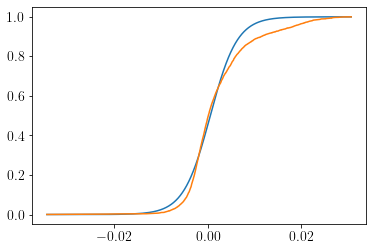

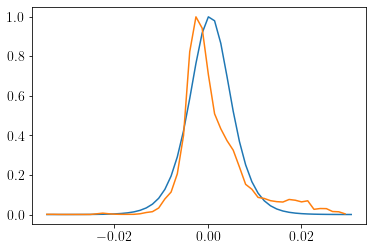

In [289]:
def gaussian(x, sigma, a, b):
    return b *np.exp(-(x+a)**2/(2 * sigma **2))

def sigmoid(x, sigma, a):
    return 1/(1 + np.exp(-(x-a)/(sigma**2)))

def sigmoid_sum(x, sigma_1, sigma_2, a_1, a_2, b):
    return (sigmoid(x, sigma_1, a_1) + b * sigmoid(x, sigma_2, a_2))/(1+b)

def d_sig(x, sigma, a):
    exp = np.exp((a-x)/sigma**2)
    return ( 1 * exp) / (sigma**2 * (exp + 1)**2)
def d_sig_sum(x, sigma_1, sigma_2, a_1, a_2, b):
    return 1/(1+b) * (d_sig(x, sigma_1, a_1) + b * d_sig(x, sigma_2, a_2))


[sigma_1, sigma_2, a_1, a_2, b], _ = scipy.optimize.curve_fit(sigmoid_sum, arr[0], arr[1]/np.max(arr[1]))
plt.plot(arr[0], sigmoid_sum(arr[0], sigma_1, sigma_2, a_1, a_2, b))
plt.plot(arr[0], arr[1]/np.max(arr[1]))
plt.show()
deriv = d_sig_sum(rs, sigma_1, sigma_2, a_1, a_2, b)

plt.plot(rs, deriv/np.max(deriv))
plt.plot(rs[:-1], diff_dist/np.max(diff_dist))

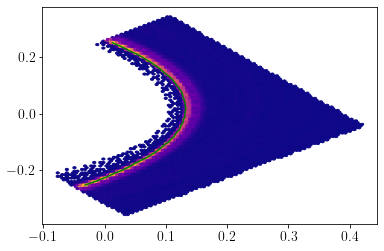

In [290]:
plt.hexbin(r * np.cos(theta), r* np.sin(theta), C = peri_novel[:,4], reduce_C_function = np.sum, cmap="plasma")
plt.plot((offsets+f(thetas))*np.cos(thetas), (offsets+f(thetas))*np.sin(thetas), "g")
# plt.plot((poly(thetas, a,b,c,d,e) + f(thetas)) * np.cos(thetas), (poly(thetas, a,b,c,d,e) + f(thetas)) * np.sin(thetas), "g")

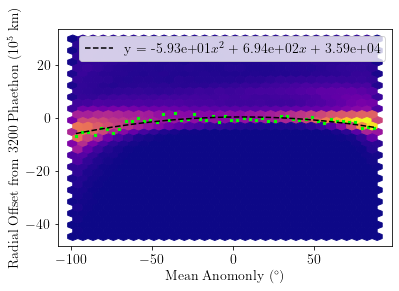

In [297]:
def poly(x, a, b, c):
    return a*(x**2) + b * (x**1)  + c 
[a,b,c] , corr = scipy.optimize.curve_fit(poly,thetas/np.pi*180, offsets*au/1000)

plt.hexbin(theta[offset_mask]/np.pi*180, offset_rs*au/1000/1e5, cmap="plasma", extent=(orbit_theta.min()/np.pi*180, orbit_theta.max()/np.pi*180, -.03*au/1000/1e5, .02*au/1000/1e5), gridsize=30)
plt.scatter(thetas/np.pi*180, offsets*au/1000/1e5, c = "lime", s=7,marker="x")
plt.plot(thetas/np.pi*180, poly(thetas/np.pi*180, a,b,c)/1e5, "k--", label = rf"y = {a:.2e}$x^2$ + {b:.2e}$x$ + {c:.2e}")
plt.legend()
plt.xlabel(r"Mean Anomonly ($^\circ$)")
plt.ylabel(r"Radial Offset from 3200 Phaethon ($10^5$ km)")
plt.savefig("../figures/novel_offsets.png")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


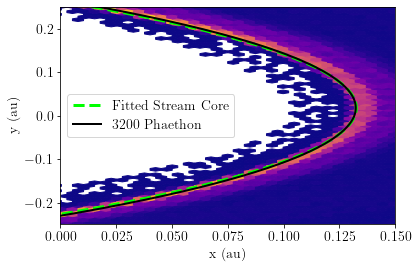

In [262]:
[a,b,c] , corr = scipy.optimize.curve_fit(poly,thetas, offsets)
plt.hexbin(r * np.cos(theta), r* np.sin(theta), C = peri_novel[:,4], reduce_C_function = np.sum, cmap="plasma")
plt.plot((poly(thetas, a, b, c)+f(thetas))*np.cos(thetas), (poly(thetas, a, b, c)+f(thetas))*np.sin(thetas), "--", color="lime",linewidth=3, label="Fitted Stream Core")

plt.plot(orbit_r * np.cos(orbit_theta), orbit_r* np.sin(orbit_theta), color="k", linewidth=2, label="3200 Phaethon")

plt.xlim(0, 0.15)
plt.ylim(-0.25, 0.25)
plt.legend(loc=6)
plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/novel_perihelion.eps")

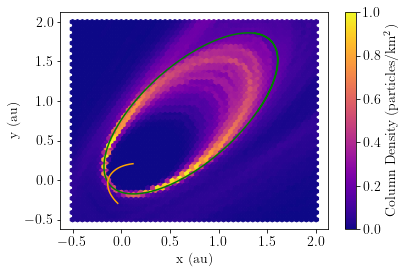

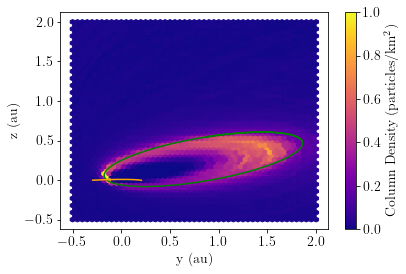

In [57]:
norm = norm_vel

x = np.linspace(-.5, 2.5, grid*2)
y = np.linspace(-.5, 2.5, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_vel[:,0], nx.flatten())), np.hstack((points_vel[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_vel[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize = grid)

# plt.clim(c_min_1, c_max_1)






plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g')
plt.plot(psp2[:,0], psp2[:,1], c='orange')

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/Fig 1.2.1.eps")
plt.show()




poly = plt.hexbin(np.hstack((points_vel[:,1], nx.flatten())), np.hstack((points_vel[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_vel[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize = grid)
# plt.clim(c_lim_2, c_max_2)





plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.2.2.eps")

plt.show()

In [5]:
r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)
peri = np.argmin(r)
grid=50
extent=(-.2,0.1,-.2,.1)

x = np.linspace(extent[0], extent[1], grid*2)
y = np.linspace(extent[2], extent[3], grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_vel[:,0], nx.flatten())), np.hstack((points_vel[:,1], ny.flatten())), cmap = "plasma", 
                  extent = extent, gridsize=grid, C = np.hstack((points_vel[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)


plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid, extent = extent)
plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot([orbit[peri,0]], [orbit[peri,1]], "r-o")
plt.scatter([0], [0], marker="*", c='y', s=500)

plt.xlim(extent[0], extent[1])
plt.ylim(extent[2], extent[3])

NameError: name 'points_vel' is not defined

  0%|          | 0/49 [00:00<?, ?it/s]

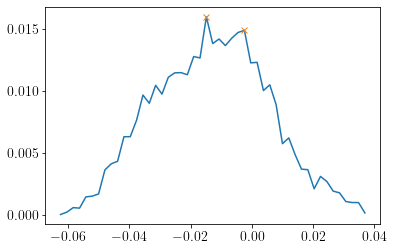

  2%|▏         | 1/49 [00:01<01:22,  1.73s/it]

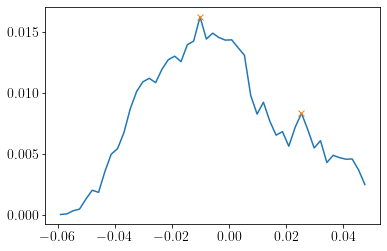

  4%|▍         | 2/49 [00:01<00:59,  1.26s/it]

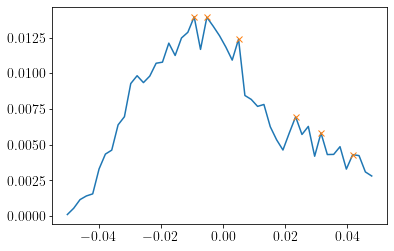

  6%|▌         | 3/49 [00:03<01:01,  1.33s/it]

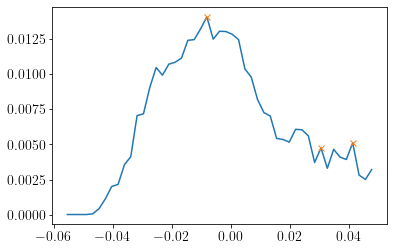

  8%|▊         | 4/49 [00:03<00:44,  1.02it/s]

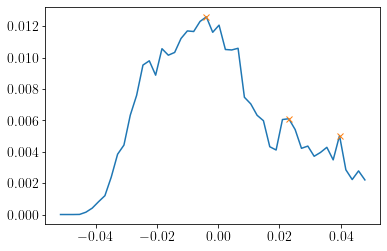

 10%|█         | 5/49 [00:05<01:00,  1.38s/it]

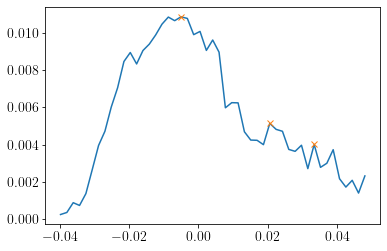

 12%|█▏        | 6/49 [00:06<00:43,  1.01s/it]

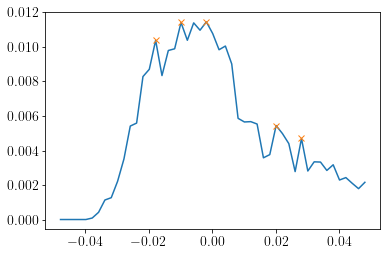

 14%|█▍        | 7/49 [00:06<00:31,  1.32it/s]

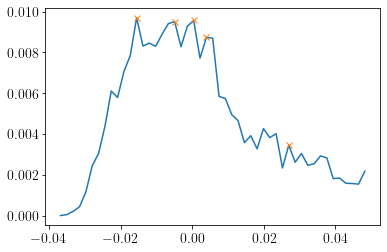

 16%|█▋        | 8/49 [00:06<00:23,  1.72it/s]

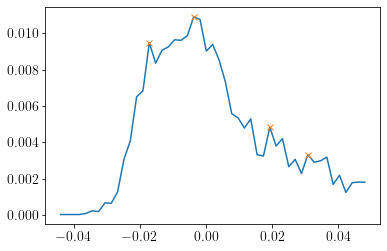

 18%|█▊        | 9/49 [00:06<00:18,  2.19it/s]

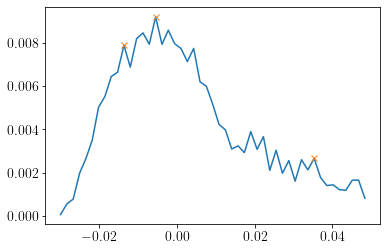

 20%|██        | 10/49 [00:06<00:14,  2.74it/s]

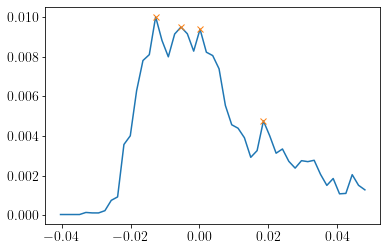

 22%|██▏       | 11/49 [00:06<00:11,  3.34it/s]

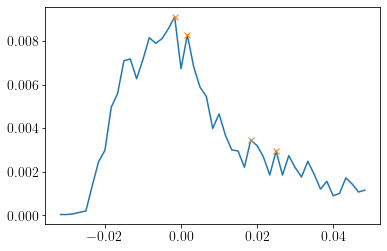

 24%|██▍       | 12/49 [00:06<00:09,  3.89it/s]

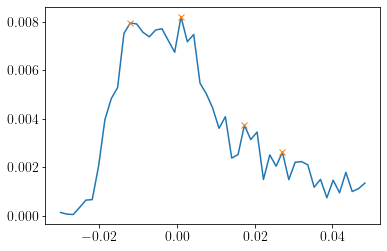

 27%|██▋       | 13/49 [00:07<00:08,  4.36it/s]

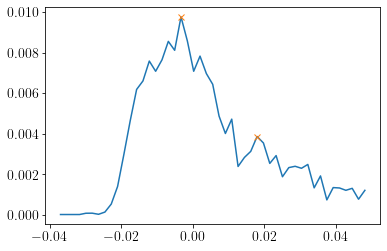

 29%|██▊       | 14/49 [00:07<00:07,  4.71it/s]

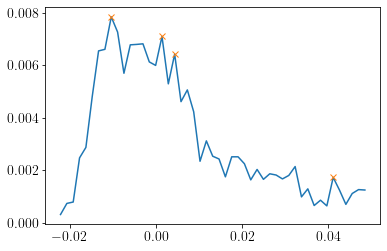

 31%|███       | 15/49 [00:07<00:06,  5.17it/s]

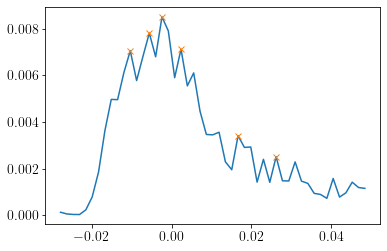

 33%|███▎      | 16/49 [00:07<00:06,  5.00it/s]

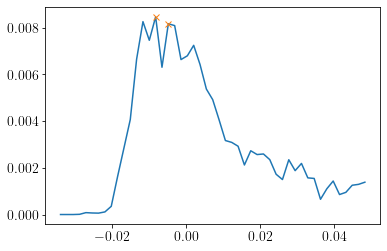

 35%|███▍      | 17/49 [00:07<00:05,  5.48it/s]

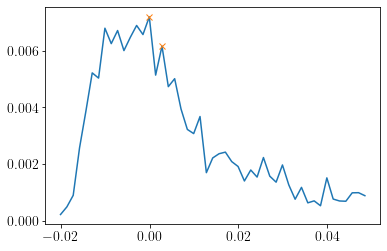

 37%|███▋      | 18/49 [00:07<00:05,  5.90it/s]

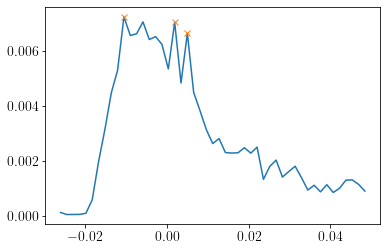

 39%|███▉      | 19/49 [00:08<00:04,  6.26it/s]

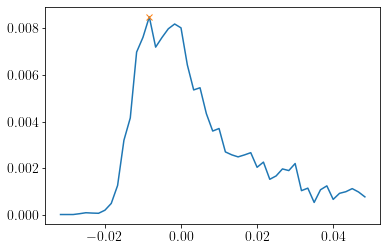

 41%|████      | 20/49 [00:08<00:04,  6.39it/s]

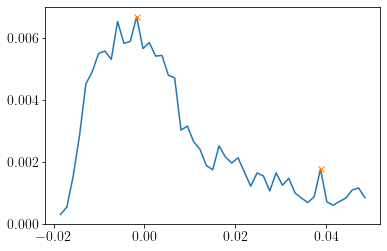

 43%|████▎     | 21/49 [00:08<00:04,  6.51it/s]

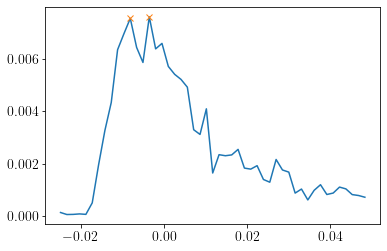

 45%|████▍     | 22/49 [00:08<00:04,  6.58it/s]

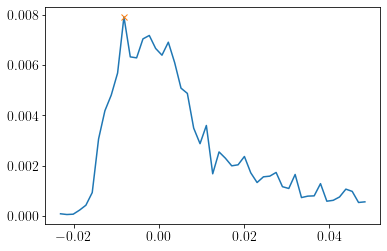

 47%|████▋     | 23/49 [00:08<00:03,  6.76it/s]

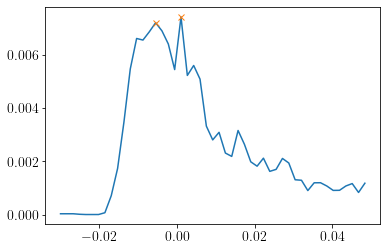

 49%|████▉     | 24/49 [00:08<00:03,  6.75it/s]

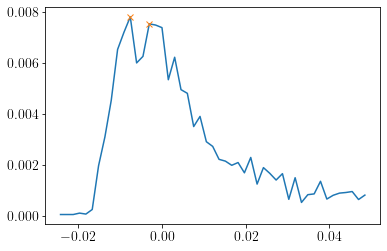

 51%|█████     | 25/49 [00:08<00:03,  6.85it/s]

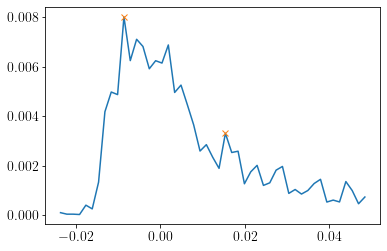

 53%|█████▎    | 26/49 [00:09<00:03,  6.82it/s]

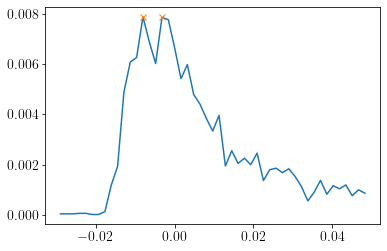

 55%|█████▌    | 27/49 [00:09<00:03,  6.83it/s]

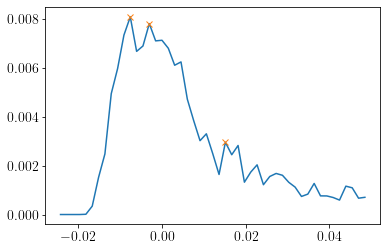

 57%|█████▋    | 28/49 [00:09<00:03,  6.74it/s]

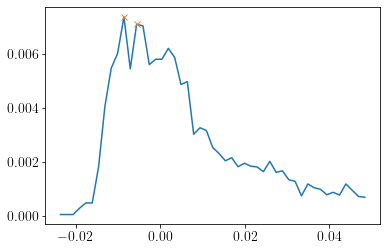

 59%|█████▉    | 29/49 [00:09<00:02,  6.72it/s]

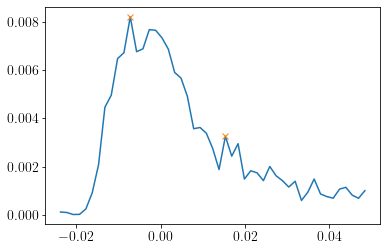

 61%|██████    | 30/49 [00:09<00:02,  6.68it/s]

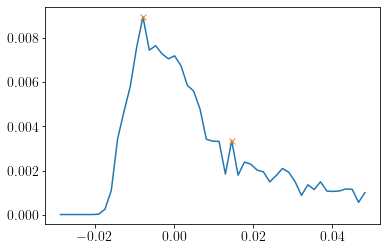

 63%|██████▎   | 31/49 [00:09<00:03,  5.98it/s]

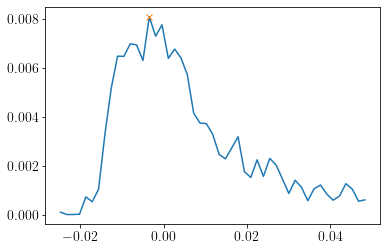

 65%|██████▌   | 32/49 [00:10<00:02,  6.23it/s]

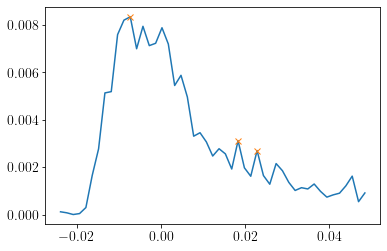

 67%|██████▋   | 33/49 [00:10<00:02,  6.50it/s]

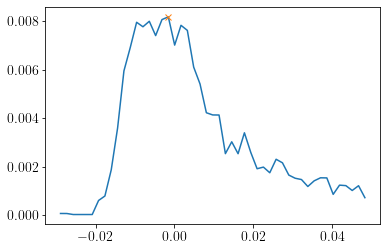

 69%|██████▉   | 34/49 [00:10<00:02,  6.64it/s]

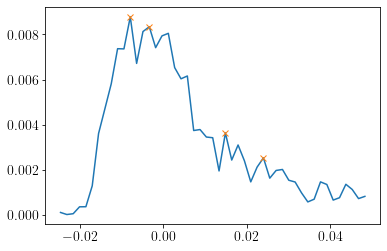

 71%|███████▏  | 35/49 [00:10<00:02,  6.79it/s]

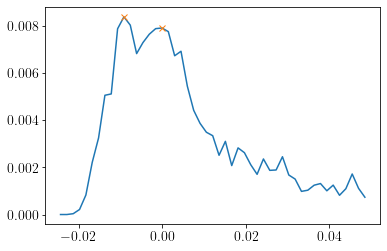

 73%|███████▎  | 36/49 [00:10<00:01,  6.82it/s]

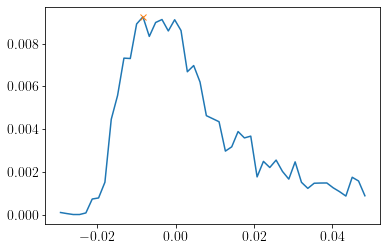

 76%|███████▌  | 37/49 [00:10<00:01,  6.95it/s]

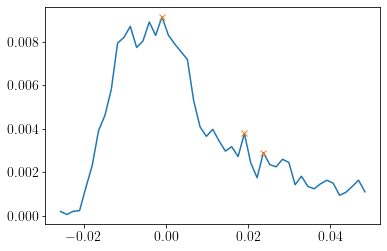

 78%|███████▊  | 38/49 [00:10<00:01,  7.03it/s]

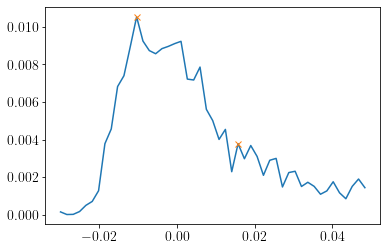

 80%|███████▉  | 39/49 [00:11<00:01,  6.96it/s]

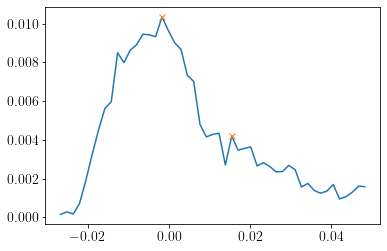

 82%|████████▏ | 40/49 [00:11<00:01,  6.90it/s]

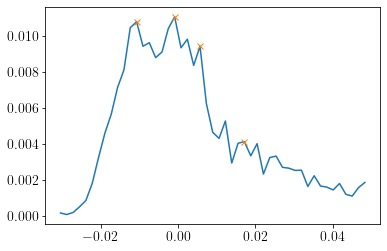

 84%|████████▎ | 41/49 [00:11<00:01,  6.89it/s]

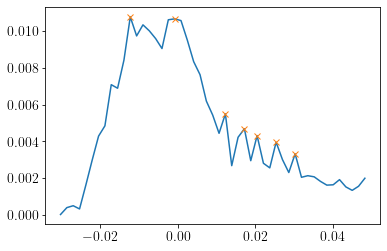

 86%|████████▌ | 42/49 [00:11<00:01,  6.92it/s]

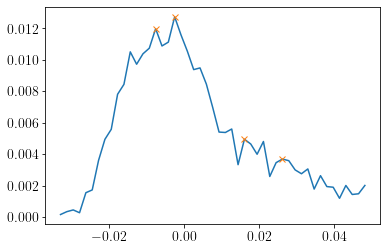

 88%|████████▊ | 43/49 [00:11<00:00,  6.81it/s]

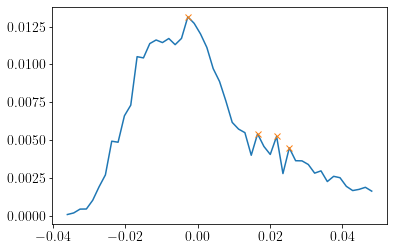

 90%|████████▉ | 44/49 [00:11<00:00,  6.67it/s]

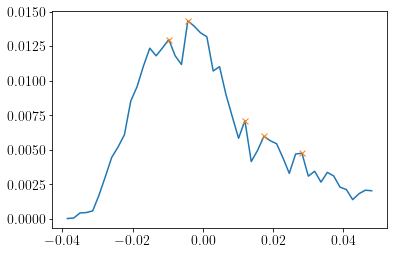

 92%|█████████▏| 45/49 [00:12<00:01,  3.42it/s]

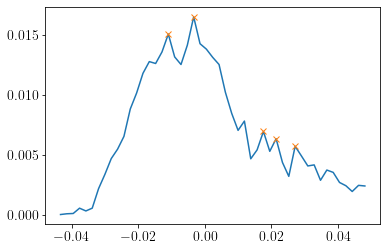

 94%|█████████▍| 46/49 [00:12<00:00,  4.02it/s]

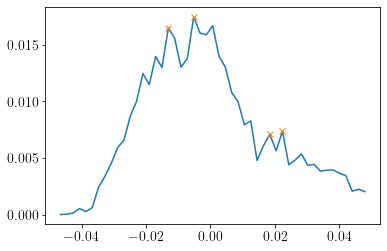

 96%|█████████▌| 47/49 [00:12<00:00,  4.62it/s]

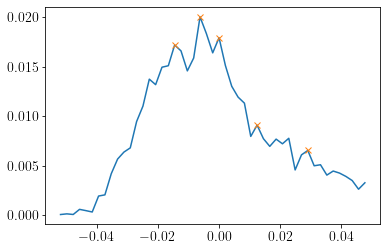

 98%|█████████▊| 48/49 [00:13<00:00,  3.11it/s]

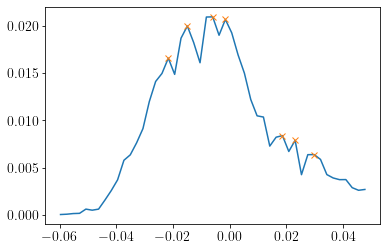

100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


In [7]:
extent=(-.3,.2,-.3,.2)

mask = (points_vel[:,0] > extent[0]) * (points_vel[:,0] < extent[1]) * (points_vel[:,1] > extent[2]) * (points_vel[:,1] < extent[3])
orbit_mask = (orbit[:,0] > extent[0]) * (orbit[:,0] < extent[1]) * (orbit[:,1] > extent[2]) * (orbit[:,1] < extent[3])
perihelion = np.array((orbit[peri,0], orbit[peri,1], orbit[peri, 2]))
point_2 = np.array((orbit[peri-10000,0], orbit[peri-10000,1], orbit[peri-10000, 2]))
p = np.sqrt(np.sum(perihelion**2))

peri_novel = points_vel[mask]
peri_orbit = orbit[orbit_mask]
point_2 = np.array([peri_orbit[0,i] for i in range(3)])
r = np.sqrt(peri_novel[:,0]**2 + peri_novel[:,1]**2 + peri_novel[:,2]**2)
orbit_r = np.sqrt(peri_orbit[:,0]**2 + peri_orbit[:,1]**2 + peri_orbit[:,2]**2)


plane = np.cross(perihelion, point_2)
plane = plane/np.sqrt(np.sum(plane**2))
n = np.cross(perihelion, plane)
n = n/np.sqrt(np.sum(n**2))


ndot= np.sum([peri_novel[:,j] * n[j] for j in range(3)], axis=0)
pdot= np.sum([peri_novel[:,j] * plane[j] for j in range(3)], axis=0)
proj = np.array([peri_novel[:,j] - pdot * plane[j] for j in range(3)])
r = np.sqrt(proj[0]**2 + proj[1]**2 + proj[2]**2)
dot = (proj[0] * perihelion[0] + proj[1] * perihelion[1] + proj[2] * perihelion[2] )
ndot[ndot >= 0] = 1
ndot[ndot <= 0] = -1
theta = np.arccos(dot/(p * r)) * ndot





# orbit_dot = (peri_orbit[:,0] * perihelion[0] + peri_orbit[:,1] * perihelion[1])
# orbit_orth = peri_orbit[:,:2] - np.array([orbit_dot / p**2 * perihelion[0], orbit_dot / p**2 * perihelion[1]]).T
# orbit_theta = np.arccos(orbit_dot/(p * orbit_r)) * orbit_orth[:, 0]/(np.abs(orbit_orth[:, 0])+1e-10)

ndot= np.sum([peri_orbit[:,j] * n[j] for j in range(3)], axis=0)
pdot= np.sum([peri_orbit[:,j] * plane[j] for j in range(3)], axis=0)
o_proj = np.array([peri_orbit[:,j] - pdot * plane[j] for j in range(3)])
orbit_r = np.sqrt(o_proj[0]**2 + o_proj[1]**2 + o_proj[2]**2)
o_dot = (o_proj[0] * perihelion[0] + o_proj[1] * perihelion[1] + o_proj[2] * perihelion[2] )
ndot[ndot >= 0] = 1
ndot[ndot <= 0] = -1
orbit_theta = np.arccos(o_dot/(p * orbit_r)) * ndot



f = scipy.interpolate.interp1d(orbit_theta, orbit_r)

midpoints = np.linspace(orbit_theta.min(), orbit_theta.max(), 50)
thetas = (midpoints[:-1] + midpoints[1:])/2
offsets = np.zeros(midpoints.shape[0] - 1)

for i in tqdm(range(1, len(midpoints))):
    mask = (theta<midpoints[i]) * (theta>midpoints[i-1])
    arr = np.array((r[mask] - f(theta[mask]),  peri_novel[mask,4]))[:, (r[mask] - f(theta[mask])).argsort()]
    arr[1] = np.cumsum(arr[1])
    try:
        # [sigma_1, sigma_2, a_1, a_2, b], _ = scipy.optimize.curve_fit(sigmoid_sum, arr[0], arr[1]/np.max(arr[1]))
        rs = np.linspace(arr[0].min(), np.min((arr[0].max(), 0.05)), 50)
    
        cume_dist = scipy.interpolate.interp1d(arr[0], arr[1])

    
        diff_dist = cume_dist(rs[1:])-cume_dist(rs[:-1])
        peaks, properties = scipy.signal.find_peaks(diff_dist, prominence=0.001)
        # offsets[i-1] = rs[np.argmax(d_sig_sum(rs, sigma_1, sigma_2, a_1, a_2, b))]
        offsets[i-1] = rs[peaks[0]]
        # deriv = d_sig_sum(rs, sigma_1, sigma_2, a_1, a_2, b)

        plt.plot(rs[:-1], diff_dist)
        plt.plot(rs[peaks], diff_dist[peaks], "x")
        # plt.plot(rs, deriv/np.max(deriv))
        # plt.plot(rs[:-1], diff_dist/np.max(diff_dist))
        plt.show()
    except Exception as e: 
        print(e)
        offsets[i-1] = offsets[i-2]

# for i in range(1, len(midpoints)):
#     mask = (theta<midpoints[i]) * (theta>midpoints[i-1])
#     arr = np.array((r[mask] - f(theta[mask]),  peri_novel[mask,4]))[:, (r[mask] - f(theta[mask])).argsort()]
#     arr[1] = np.cumsum(arr[1])
    
#     cume_dist = scipy.interpolate.interp1d(arr[0], arr[1])
#     rs = np.linspace(arr[0].min(), np.min((arr[0].max())), 30)
#     diff_dist = cume_dist(rs[1:])-cume_dist(rs[:-1])
#     offsets[i-1] = (rs[np.argmax(diff_dist)] + rs[np.argmax(diff_dist) + 1])/2
    
    
    
    # target = arr[1,-1] * .3
    # j = np.searchsorted(arr[1], target)
    # offsets[i-1] = arr[0,j]
    

offset_mask = (theta < orbit_theta.max()) * (theta > orbit_theta.min())
offset_rs = r[offset_mask] - f(theta[offset_mask])


In [277]:
o_proj

array([[-0.1778315 , -0.17789919, -0.17796349, ...,  0.19636874,
         0.1978248 ,  0.19927727],
       [ 0.19999662,  0.19840069,  0.19680113, ..., -0.16991771,
        -0.16970287, -0.16948482],
       [-0.0822218 , -0.08218771, -0.08215206, ...,  0.08880115,
         0.08940193,  0.09000109]])

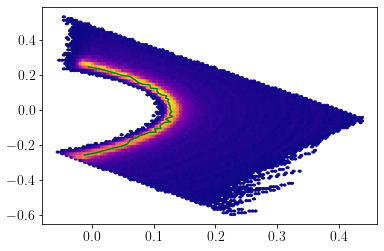

In [278]:
plt.hexbin(r * np.cos(theta), r* np.sin(theta), C = peri_novel[:,4], reduce_C_function = np.sum, cmap="plasma")
plt.plot((offsets+f(thetas))*np.cos(thetas), (offsets+f(thetas))*np.sin(thetas), "g")
# plt.plot((poly(thetas, a,b,c,d,e) + f(thetas)) * np.cos(thetas), (poly(thetas, a,b,c,d,e) + f(thetas)) * np.sin(thetas), "g")

In [279]:
o_proj[2].mean()

-0.017348193834457504

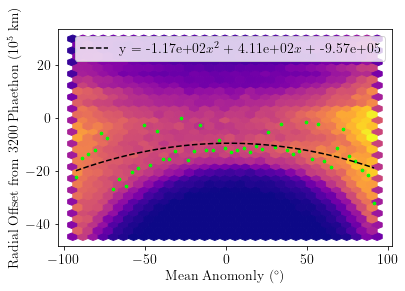

In [280]:
def poly(x, a, b, c):
    return a*(x**2) + b * (x**1)  + c 
[a,b,c] , corr = scipy.optimize.curve_fit(poly,thetas/np.pi*180, offsets*au/1000)

plt.hexbin(theta[offset_mask]/np.pi*180, offset_rs*au/1000/1e5, cmap="plasma", extent=(orbit_theta.min()/np.pi*180, orbit_theta.max()/np.pi*180, -.03*au/1000/1e5, .02*au/1000/1e5), gridsize=30)
plt.scatter(thetas/np.pi*180, offsets*au/1000/1e5, c = "lime", s=7)
plt.plot(thetas/np.pi*180, poly(thetas/np.pi*180, a,b,c)/1e5, "k--", label = rf"y = {a:.2e}$x^2$ + {b:.2e}$x$ + {c:.2e}")
plt.legend()
plt.xlabel(r"Mean Anomonly ($^\circ$)")
plt.ylabel(r"Radial Offset from 3200 Phaethon ($10^5$ km)")
plt.savefig("../figures/vel_offsets.png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


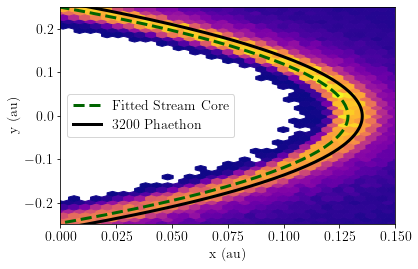

In [252]:
[a,b,c] , corr = scipy.optimize.curve_fit(poly,thetas, offsets)
plt.hexbin(r * np.cos(theta), r* np.sin(theta), C = peri_novel[:,4], reduce_C_function = np.sum, cmap="plasma")
plt.plot((poly(thetas, a, b, c)+f(thetas))*np.cos(thetas), (poly(thetas, a, b, c)+f(thetas))*np.sin(thetas), "--", color="darkgreen",linewidth=3, label="Fitted Stream Core")

plt.plot(orbit_r * np.cos(orbit_theta), orbit_r* np.sin(orbit_theta), color="k", linewidth=3, label="3200 Phaethon")

plt.xlim(0, 0.15)
plt.ylim(-0.25, 0.25)
plt.legend(loc=6)
plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/vel_perihelion.eps")

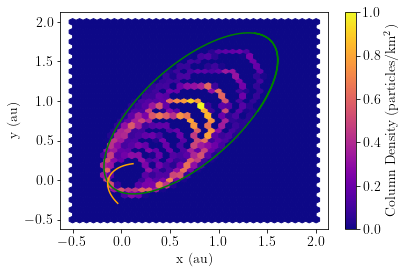

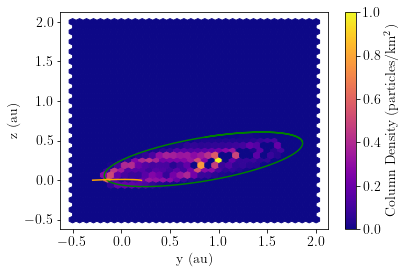

In [8]:
norm = 1
grid = 35

mask = points_distr[:,3] > 1e-10
points_distr = points_distr[mask]

x = np.linspace(-.5, 2.5, grid*2)
y = np.linspace(-.5, 2.5, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_distr[:,0], nx.flatten())), np.hstack((points_distr[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_distr[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)

# plt.clim(c_min_1, c_max_1)






plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g')
plt.plot(psp2[:,0], psp2[:,1], c='orange')

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/Fig 1.3.1.eps")
plt.show()







poly = plt.hexbin(np.hstack((points_distr[:,1], nx.flatten())), np.hstack((points_distr[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_distr[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)





plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.3.2.eps")
plt.show()

In [282]:
# norm = norm_distr
# grid = 35

# mask = points_distr[:,3] > 0

# points_distr = points_distr[mask]
# extent = (-1.5,3.,-1.5,3.)
# x = np.linspace(extent[0], extent[1], grid*2)
# y = np.linspace(extent[2], extent[3], grid*2)
# c = np.zeros((grid*2)**2)
# nx, ny = np.meshgrid(x, y)

# poly = plt.hexbin(np.hstack((points_distr[:,0], nx.flatten())), np.hstack((points_distr[:,1], ny.flatten())), cmap = "plasma", 
#                   extent = extent, gridsize=grid, C = np.hstack((points_distr[:,4], c)),
#                   reduce_C_function = np.sum)

# plt.close()
# offsets = poly.get_offsets()
# C = poly.get_array()

# dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
# dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

# V = 2*dx*dy*(au**2)/(1e3**2)

# plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)

# # plt.clim(c_min_1, c_max_1)






# plt.colorbar(label = "Column Density (particles/km$^2$)")
# plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g')
# plt.plot(psp2[:,0], psp2[:,1], c='orange')

# plt.xlabel("x (au)")
# plt.ylabel("y (au)")
# plt.savefig("../figures/Fig 1.3.1.eps")
# plt.show()







# poly = plt.hexbin(np.hstack((points_distr[:,1], nx.flatten())), np.hstack((points_distr[:,2], ny.flatten())), cmap = "plasma", 
#                   extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_distr[:,4], c)),
#                   reduce_C_function = np.sum)
# plt.close()
# offsets = poly.get_offsets()
# C = poly.get_array()

# dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
# dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

# V = 2*dx*dy*(au**2)/(1e3**2)

# plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# # plt.clim(c_lim_2, c_max_2)





# plt.colorbar(label = "Column Density (particles/km$^2$)")

# plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
# plt.plot(psp2[:,1], psp2[:,2], c='orange')

# plt.xlabel("y (au)")
# plt.ylabel("z (au)")
# # plt.savefig("../figures/Fig 1.3.2.eps")
# # plt.show()

(-0.2, 0.1)

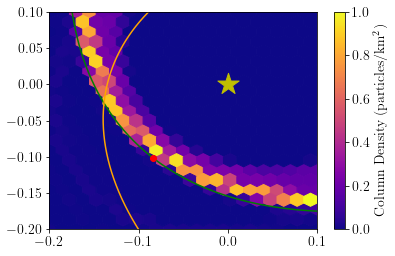

In [6]:
r = np.sqrt(orbit[:,0]**2 + orbit[:,1]**2 + orbit[:,2]**2)
peri = np.argmin(r)
grid=20
extent=(-.2,0.1,-.2,.1)

x = np.linspace(extent[0], extent[1], grid*2)
y = np.linspace(extent[2], extent[3], grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)
grid=20
poly = plt.hexbin(np.hstack((points_distr[:,0], nx.flatten())), np.hstack((points_distr[:,1], ny.flatten())), cmap = "plasma", 
                  extent = extent, gridsize=grid, C = np.hstack((points_distr[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)


plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid, extent = extent)
plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot([orbit[peri,0]], [orbit[peri,1]], "r-o")
plt.scatter([0], [0], marker="*", c='y', s=500)
plt.plot(psp2[:,0], psp2[:,1], c='orange')


plt.xlim(extent[0], extent[1])
plt.ylim(extent[2], extent[3])

In [7]:
extent=(-.3,.2,-.3,.2)

mask = (points_distr[:,0] > extent[0]) * (points_distr[:,0] < extent[1]) * (points_distr[:,1] > extent[2]) * (points_distr[:,1] < extent[3])
orbit_mask = (orbit[:,0] > extent[0]) * (orbit[:,0] < extent[1]) * (orbit[:,1] > extent[2]) * (orbit[:,1] < extent[3])
perihelion = np.array((orbit[peri,0], orbit[peri,1]))
p = np.sqrt(np.sum(perihelion**2))

peri_novel = points_distr[mask]
peri_orbit = orbit[orbit_mask]
r = np.sqrt(peri_novel[:,0]**2 + peri_novel[:,1]**2)
orbit_r = np.sqrt(peri_orbit[:,0]**2 + peri_orbit[:,1]**2)

dot = (peri_novel[:,0] * perihelion[0] + peri_novel[:,1] * perihelion[1] )
orth = peri_novel[:,:2] - np.array([dot / p**2 * perihelion[0], dot / p**2 * perihelion[1]]).T
theta = np.arccos(dot/(p * r)) * orth[:, 0]/(np.abs(orth[:, 0])+1e-10)




orbit_dot = (peri_orbit[:,0] * perihelion[0] + peri_orbit[:,1] * perihelion[1])
orbit_orth = peri_orbit[:,:2] - np.array([orbit_dot / p**2 * perihelion[0], orbit_dot / p**2 * perihelion[1]]).T
orbit_theta = np.arccos(orbit_dot/(p * orbit_r)) * orbit_orth[:, 0]/(np.abs(orbit_orth[:, 0])+1e-10)

f = scipy.interpolate.interp1d(orbit_theta, orbit_r)

midpoints = np.linspace(orbit_theta.min(), orbit_theta.max(), 50)
thetas = (midpoints[:-1] + midpoints[1:])/2
offsets = np.zeros(midpoints.shape[0] - 1)

for i in range(1, len(midpoints)):
    mask = (theta<midpoints[i]) * (theta>midpoints[i-1])
    arr = np.array((r[mask] - f(theta[mask]),  peri_novel[mask,4]))[:, (r[mask] - f(theta[mask])).argsort()]
    arr[1] = np.cumsum(arr[1])
    
    cume_dist = scipy.interpolate.interp1d(arr[0], arr[1])
    rs = np.linspace(arr[0].min(), np.min((arr[0].max())), 50)
    diff_dist = cume_dist(rs[1:])-cume_dist(rs[:-1])
    offsets[i-1] = (rs[np.argmax(diff_dist)] + rs[np.argmax(diff_dist) + 1])/2
    
    
    
    # target = arr[1,-1] * .3
    # j = np.searchsorted(arr[1], target)
    # offsets[i-1] = arr[0,j]
    

offset_mask = (theta < orbit_theta.max()) * (theta > orbit_theta.min())
offset_rs = r[offset_mask] - f(theta[offset_mask])


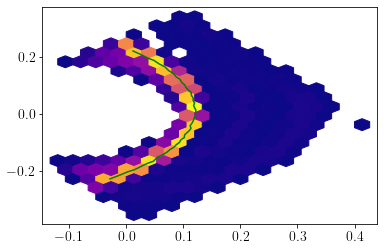

In [8]:
plt.hexbin(r * np.cos(theta), r* np.sin(theta), C = peri_novel[:,4], reduce_C_function = np.sum, cmap="plasma", gridsize=grid)
plt.plot((offsets+f(thetas))*np.cos(thetas), (offsets+f(thetas))*np.sin(thetas), "g")

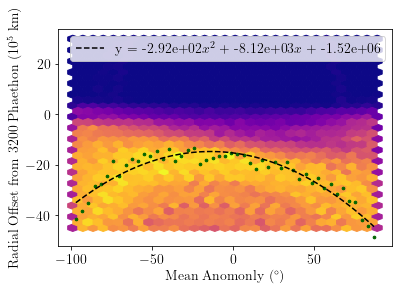

In [9]:
def poly(x, a, b, c):
    return a*(x**2) + b * (x**1)  + c 
[a,b,c] , corr = scipy.optimize.curve_fit(poly,thetas/np.pi*180, offsets*au/1000)

plt.hexbin(theta[offset_mask]/np.pi*180, offset_rs*au/1000/1e5, cmap="plasma", extent=(orbit_theta.min()/np.pi*180, orbit_theta.max()/np.pi*180, -.03*au/1000/1e5, .02*au/1000/1e5), gridsize=30)
plt.scatter(thetas/np.pi*180, offsets*au/1000/1e5, c = "darkgreen", s=7)
plt.plot(thetas/np.pi*180, poly(thetas/np.pi*180, a,b,c)/1e5, "k--", label = rf"y = {a:.2e}$x^2$ + {b:.2e}$x$ + {c:.2e}")
plt.legend()
plt.xlabel(r"Mean Anomonly ($^\circ$)")
plt.ylabel(r"Radial Offset from 3200 Phaethon ($10^5$ km)")
plt.savefig("../figures/distr_offsets.png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


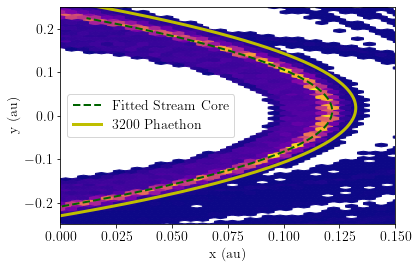

In [12]:
[a,b,c] , corr = scipy.optimize.curve_fit(poly,thetas, offsets)
plt.hexbin(r * np.cos(theta), r* np.sin(theta), C = peri_novel[:,4], reduce_C_function = np.sum, cmap="plasma")
plt.plot((poly(thetas, a, b, c)+f(thetas))*np.cos(thetas), (poly(thetas, a, b, c)+f(thetas))*np.sin(thetas),"--", color="darkgreen",linewidth=2, label="Fitted Stream Core")

plt.plot(orbit_r * np.cos(orbit_theta), orbit_r* np.sin(orbit_theta), color="y", linewidth=3, label="3200 Phaethon")

plt.xlim(0, 0.15)
plt.ylim(-0.25, 0.25)
plt.legend(loc=6)
plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/distr_periheilion.eps")

In [14]:
points_distr[:,3][points_distr[:,3] > 0].max()

2.821358222603491e-05

In [7]:
points_distr.shape[0]/20000

2682.0

In [21]:
a = np.array([points_distr[i,:] for i in range(2682)])


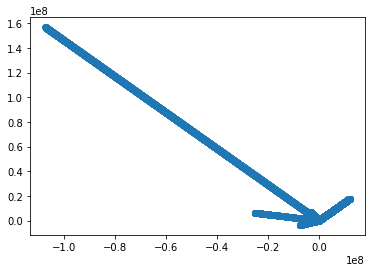

In [25]:
plt.scatter(points_distr[:,0], points_distr[:,1])

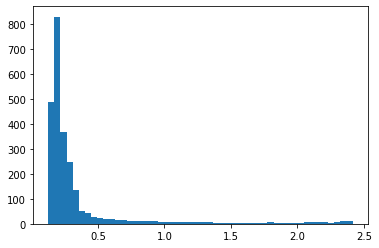

In [33]:

plt.hist(points_distr[:,5], weights=points_distr[:,4], bins=50)
plt.show()

In [ ]:
points_distr[:,4]*points_distr[:,3]

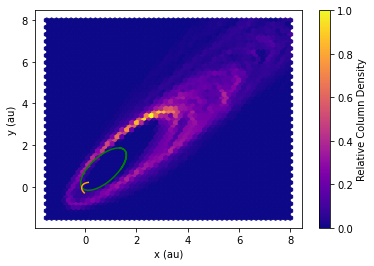

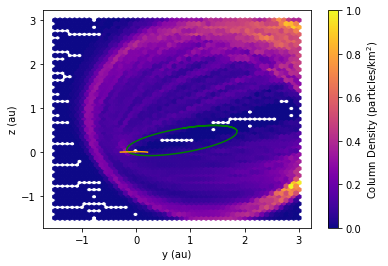

In [27]:
norm = norm_novel
grid=50
points_novel2 = points_novel[points_novel[:,3] < 1e-8]
x = np.linspace(-1.5, 8, grid*2)
y = np.linspace(-1.5, 8, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_novel2[:,0], nx.flatten())), np.hstack((points_novel2[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-1.5,8.,-1.5,8.), gridsize=grid, C = np.hstack((points_novel2[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=int(grid))






plt.colorbar(label = "Relative Column Density")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot(psp2[:,0], psp2[:,1], c='orange', label = "Parker Solar Probe")

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/small_particles_novel.png")
plt.show()



poly = plt.hexbin(np.hstack((points_novel2[:,1], nx.flatten())), np.hstack((points_novel2[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-1.5,3.,-1.5,3.), gridsize=grid, C = np.hstack((points_novel2[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)




plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.2.eps")
plt.show()

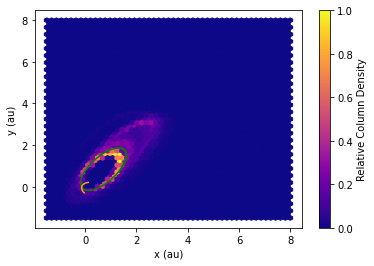

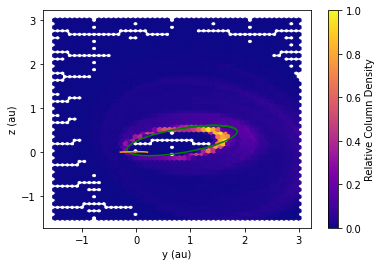

In [33]:
norm = norm_novel
grid=50
points_novel2 = points_novel[np.logical_and(points_novel[:,3] > 1e-8, points_novel[:,3] < 10**-7.8)]
x = np.linspace(-1.5, 8, grid*2)
y = np.linspace(-1.5, 8, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_novel2[:,0], nx.flatten())), np.hstack((points_novel2[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-1.5,8.,-1.5,8.), gridsize=grid, C = np.hstack((points_novel2[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)






plt.colorbar(label = "Relative Column Density")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot(psp2[:,0], psp2[:,1], c='orange', label = "Parker Solar Probe")

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/Medium Particles.png")
plt.show()



poly = plt.hexbin(np.hstack((points_novel2[:,1], nx.flatten())), np.hstack((points_novel2[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-1.5,3.,-1.5,3.), gridsize=grid, C = np.hstack((points_novel2[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)




plt.colorbar(label = "Relative Column Density")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.2.eps")
plt.show()

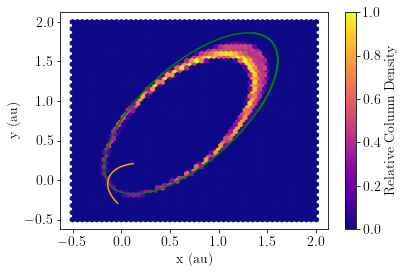

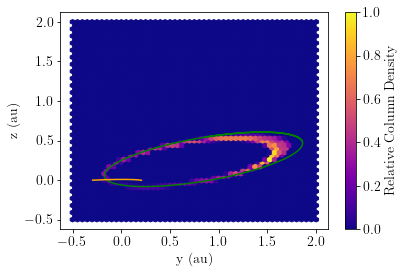

In [7]:

grid=50
points_novel2 = points_novel[np.logical_and(points_novel[:,3] > 1e-7, points_novel[:,3] < 10**-6)]
x = np.linspace(-0.5, 2, grid*2)
y = np.linspace(-0.5, 2, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_novel2[:,0], nx.flatten())), np.hstack((points_novel2[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-0.5,2.,-0.5,2.), gridsize=grid, C = np.hstack((points_novel2[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)






plt.colorbar(label = "Relative Column Density")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot(psp2[:,0], psp2[:,1], c='orange', label = "Parker Solar Probe")

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/Medium Particles.png")
plt.show()



poly = plt.hexbin(np.hstack((points_novel2[:,1], nx.flatten())), np.hstack((points_novel2[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-0.5,2.,-0.5,2.), gridsize=grid, C = np.hstack((points_novel2[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)




plt.colorbar(label = "Relative Column Density")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.2.eps")
plt.show()